In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Optimization
from hyperopt import fmin, tpe, hp, STATUS_OK

# Seeding
import random
random.seed(42)  # Set random seed for Python
np.random.seed(42)  # Set random seed for NumPy

In [34]:
train = pd.read_csv('../data_format1/train_format1.csv')
user_info = pd.read_csv('../data_format1/user_info_format1.csv')
test = pd.read_csv('../data_format1/test_format1.csv')

In [35]:
train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [36]:
test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [37]:
user_log = pd.read_csv('../data_format1/user_log_format1.csv')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d', errors='coerce')
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,1900-08-29,0
1,328862,844400,1271,2882,2661.0,1900-08-29,0
2,328862,575153,1271,2882,2661.0,1900-08-29,0
3,328862,996875,1271,2882,2661.0,1900-08-29,0
4,328862,1086186,1271,1253,1049.0,1900-08-29,0


In [38]:
# Extract meaningful features
user_log['day_of_week'] = user_log['time_stamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
user_log['month'] = user_log['time_stamp'].dt.month            # Month of the action


In [39]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [40]:
# Merge user info with train dataset
train = train.merge(user_info, on='user_id', how='left')
test = test.merge(user_info, on='user_id', how='left')
train.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


# User Based Features

In [9]:
# Aggregating time-based features
time_features = user_log.groupby('user_id').agg({
    'day_of_week': lambda x: x.value_counts().idxmax(),  # Most common interaction day
    'month': lambda x: x.value_counts().idxmax()         # Most active month
}).reset_index()

# Rename columns for clarity
time_features.columns = ['user_id', 'most_active_day', 'most_active_month']
time_features.head()

,user_id,most_active_day,most_active_month
0,1,6,11
1,2,1,6
2,3,4,11
3,4,6,11
4,5,6,10


In [10]:
#  user-level features
user_features = user_log.groupby('user_id').agg({
    'item_id': 'count',       # Total interactions
    'cat_id': 'nunique',      # Unique categories
    'seller_id': 'nunique',   # Unique merchants
    'brand_id': 'nunique',    # Unique brands
    'time_stamp': 'nunique',  # Active days
}).reset_index()

# Rename columns for clarity
user_features.rename(columns={
    'item_id': 'total_interactions',
    'cat_id': 'unique_categories',
    'seller_id': 'unique_merchants',
    'brand_id': 'unique_brands',
    'time_stamp': 'active_days'
}, inplace=True)

user_features = user_features.merge(time_features, how='left', on='user_id')
user_features.head()

,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,most_active_day,most_active_month
0,1,33,6,9,9,5,6,11
1,2,63,14,14,15,9,1,6
2,3,68,19,23,22,13,4,11
3,4,50,13,12,12,10,6,11
4,5,173,40,56,59,30,6,10


In [11]:
# Add action type-specific counts
action_counts = user_log.groupby('user_id')['action_type'].value_counts().unstack(fill_value=0).reset_index()
action_counts.columns = ['user_id', 'total_clicks', 'total_carts', 'total_purchases', 'total_favs']

# Merge action counts with general features
user_features = user_features.merge(action_counts, on='user_id', how='left')

# Add ratio and conversion features
user_features['total_actions'] = user_features[['total_clicks', 'total_carts', 'total_purchases', 'total_favs']].sum(axis=1)
user_features['click_ratio'] = user_features['total_clicks'] / user_features['total_actions']
user_features['purchase_ratio'] = user_features['total_purchases'] / user_features['total_actions']
user_features['add_to_cart_ratio'] = user_features['total_carts'] / user_features['total_actions']
user_features['favorite_ratio'] = user_features['total_favs'] / user_features['total_actions']

# Direct abandonment rates
user_features['cart_abandonment_rate'] = np.where(
    user_features['total_carts'] > 0,
    (user_features['total_carts'] - user_features['total_purchases']) / user_features['total_carts'],
    0
)

user_features['fav_abandonment_rate'] = np.where(
    user_features['total_favs'] > 0,
    (user_features['total_favs'] - user_features['total_purchases']) / user_features['total_favs'],
    0
)

# Weighted abandonment rates (relative to total actions)
user_features['weighted_cart_abandonment_rate'] = (
    (user_features['total_carts'] - user_features['total_purchases']) / user_features['total_actions']
)

user_features['weighted_fav_abandonment_rate'] = (
    (user_features['total_favs'] - user_features['total_purchases']) / user_features['total_actions']
)

user_features.head()

,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,most_active_day,most_active_month,total_clicks,total_carts,...,total_favs,total_actions,click_ratio,purchase_ratio,add_to_cart_ratio,favorite_ratio,cart_abandonment_rate,fav_abandonment_rate,weighted_cart_abandonment_rate,weighted_fav_abandonment_rate
0,1,33,6,9,9,5,6,11,27,0,...,0,33,0.818182,0.181818,0.0,0.000000,0.0,0.0,-0.181818,-0.181818
1,2,63,14,14,15,9,1,6,47,0,...,2,63,0.746032,0.222222,0.0,0.031746,0.0,-6.0,-0.222222,-0.190476
2,3,68,19,23,22,13,4,11,63,0,...,1,68,0.926471,0.058824,0.0,0.014706,0.0,-3.0,-0.058824,-0.044118
3,4,50,13,12,12,10,6,11,49,0,...,0,50,0.980000,0.020000,0.0,0.000000,0.0,0.0,-0.020000,-0.020000
4,5,173,40,56,59,30,6,10,150,0,...,10,173,0.867052,0.075145,0.0,0.057803,0.0,-0.3,-0.075145,-0.017341


In [12]:
# Diversity features
user_features['category_preference'] = user_log.groupby('user_id')['cat_id'].apply(lambda x: x.value_counts(normalize=True).max()).values
user_features['merchant_preference'] = user_log.groupby('user_id')['seller_id'].apply(lambda x: x.value_counts(normalize=True).max()).values
user_features['brand_preference'] = user_log.groupby('user_id')['brand_id'].apply(lambda x: x.value_counts(normalize=True).max()).values

# Behavioral patterns
user_features['action_entropy'] = user_log.groupby('user_id')['action_type'].apply(
    lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True))))
).values

# Repeat behavior features
user_features['repeat_category_ratio'] = user_log.groupby('user_id')['cat_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

user_features['repeat_brand_ratio'] = user_log.groupby('user_id')['brand_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

user_features['repeat_merchant_ratio'] = user_log.groupby('user_id')['seller_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

# Check final features
user_features.head()


,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,most_active_day,most_active_month,total_clicks,total_carts,...,fav_abandonment_rate,weighted_cart_abandonment_rate,weighted_fav_abandonment_rate,category_preference,merchant_preference,brand_preference,action_entropy,repeat_category_ratio,repeat_brand_ratio,repeat_merchant_ratio
0,1,33,6,9,9,5,6,11,27,0,...,0.0,-0.181818,-0.181818,0.424242,0.424242,0.424242,0.684038,0.151515,0.121212,0.121212
1,2,63,14,14,15,9,1,6,47,0,...,-6.0,-0.222222,-0.190476,0.317460,0.412698,0.317460,0.955555,0.126984,0.111111,0.095238
2,3,68,19,23,22,13,4,11,63,0,...,-3.0,-0.058824,-0.044118,0.161765,0.220588,0.235294,0.432042,0.205882,0.161765,0.161765
3,4,50,13,12,12,10,6,11,49,0,...,0.0,-0.020000,-0.020000,0.460000,0.500000,0.500000,0.141441,0.100000,0.120000,0.120000
4,5,173,40,56,59,30,6,10,150,0,...,-0.3,-0.075145,-0.017341,0.121387,0.104046,0.104651,0.696780,0.167630,0.156069,0.150289


<!-- ## Merchant based Features -->

# Merchant Based Features

In [13]:
# Base merchant-level aggregation
merchant_features = user_log.groupby('seller_id').agg({
    'user_id': 'nunique',  # Total unique users
    'item_id': 'count',    # Total interactions
    'cat_id': 'nunique',   # Unique categories
    'brand_id': 'nunique', # Unique brands
}).reset_index()

# Rename columns for clarity
merchant_features.rename(columns={
    'seller_id': 'merchant_id',
    'user_id': 'total_users',
    'item_id': 'total_interactions',
    'cat_id': 'unique_categories',
    'brand_id': 'unique_brands'
}, inplace=True)

# User engagement metrics
merchant_user_counts = user_log.groupby('seller_id')['user_id'].value_counts().groupby('seller_id').agg(['mean', 'std', 'max']).reset_index()
merchant_user_counts.rename(columns={
    'mean': 'avg_interactions_per_user',
    'std': 'std_interactions_per_user',
    'max': 'max_interactions_by_single_user'
}, inplace=True)

merchant_features = merchant_features.merge(
    merchant_user_counts[['seller_id', 'avg_interactions_per_user', 'std_interactions_per_user', 'max_interactions_by_single_user']],
    left_on='merchant_id', right_on='seller_id', how='left'
).drop('seller_id', axis=1)

# Popularity metrics
merchant_features['user_interaction_ratio'] = merchant_features['total_users'] / merchant_features['total_interactions']

# Diversity metrics
merchant_features['category_concentration'] = user_log.groupby('seller_id')['cat_id'].apply(
    lambda x: x.value_counts(normalize=True).max()
).values

merchant_features['brand_concentration'] = user_log.groupby('seller_id')['brand_id'].apply(
    lambda x: x.value_counts(normalize=True).max()
).values

# Behavioral metrics
merchant_features['repeat_user_ratio'] = user_log.groupby('seller_id')['user_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

merchant_features['action_entropy'] = user_log.groupby('seller_id')['action_type'].apply(
    lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True))))
).values

# Conversion metrics (if purchases exist)
merchant_action_counts = user_log.groupby('seller_id')['action_type'].value_counts().unstack(fill_value=0).reset_index()
merchant_action_counts.columns = ['merchant_id', 'total_clicks', 'total_carts', 'total_purchases', 'total_favs']

merchant_features = merchant_features.merge(merchant_action_counts, on='merchant_id', how='left')

merchant_features['purchase_ratio'] = merchant_features['total_purchases'] / merchant_features['total_interactions']
merchant_features['cart_conversion_rate'] = merchant_features['total_purchases'] / (merchant_features['total_carts'] + 1e-9)
merchant_features['favorite_conversion_rate'] = merchant_features['total_purchases'] / (merchant_features['total_favs'] + 1e-9)

# Final features
merchant_features.head()


,merchant_id,total_users,total_interactions,unique_categories,unique_brands,avg_interactions_per_user,std_interactions_per_user,max_interactions_by_single_user,user_interaction_ratio,category_concentration,brand_concentration,repeat_user_ratio,action_entropy,total_clicks,total_carts,total_purchases,total_favs,purchase_ratio,cart_conversion_rate,favorite_conversion_rate
0,1,30796,339140,44,2,11.012469,25.910812,702,0.090806,0.229062,0.979120,0.062959,0.538198,308236,444,17705,12755,0.052206,39.876126,1.388083
1,2,936,2371,10,1,2.533120,3.207107,36,0.394770,0.393505,1.000000,0.167440,0.755827,2030,8,189,144,0.079713,23.625000,1.312500
2,3,1136,2645,4,1,2.328345,3.383105,55,0.429490,0.886200,1.000000,0.168242,0.535448,2399,4,67,175,0.025331,16.750000,0.382857
3,4,1481,3106,7,2,2.097232,2.484003,28,0.476819,0.804894,0.995487,0.169028,0.749813,2646,2,294,164,0.094656,147.000000,1.792683
4,5,3652,8192,23,1,2.243154,3.208456,54,0.445801,0.457764,1.000000,0.168945,0.495989,7483,9,144,556,0.017578,16.000000,0.258993


# User-Merchant Interaction Features

In [14]:
# # Base aggregation
# interaction_features = user_log.groupby(['user_id', 'seller_id']).agg({
#     'time_stamp': ['count', 'nunique'],  # Total interactions, active days
#     'action_type': ['count', lambda x: (x == 0).sum(), lambda x: (x == 1).sum(), lambda x: (x == 2).sum(), lambda x: (x == 3).sum()],
# }).reset_index()

# # Rename columns for clarity
# interaction_features.columns = [
#     'user_id', 'merchant_id', 'user_merchant_interactions', 
#     'user_merchant_active_days', 'total_actions', 
#     'user_merchant_clicks', 'user_merchant_carts', 
#     'user_merchant_purchases', 'user_merchant_favs'
# ]

# # Ratio features
# interaction_features['purchase_ratio'] = interaction_features['user_merchant_purchases'] / interaction_features['total_actions']

# interaction_features['cart_conversion_rate'] = np.where(
#     user_features['user_merchant_carts'] > 0,
#     interaction_features['user_merchant_purchases'] / interaction_features['user_merchant_carts'],
#     0
# )

# interaction_features['favorite_conversion_rate'] = np.where(
#     user_features['user_merchant_carts'] > 0,
#     interaction_features['user_merchant_purchases'] / interaction_features['user_merchant_favs'],
#     0
# )

In [15]:
# # Loyalty features
# interaction_features['interaction_frequency'] = interaction_features['user_merchant_interactions'] / interaction_features['user_merchant_active_days']
# interaction_features['loyalty_score'] = interaction_features['user_merchant_purchases'] / interaction_features['user_merchant_interactions']

# # Diversity features
# interaction_features['unique_categories'] = user_log.groupby(['user_id', 'seller_id'])['cat_id'].nunique().reset_index()['cat_id']
# interaction_features['unique_brands'] =  user_log.groupby(['user_id', 'seller_id'])['brand_id'].nunique().reset_index()['brand_id']

# # Behavioral patterns
# interaction_features['action_entropy'] = user_log.groupby(['user_id', 'seller_id'])['action_type'].apply(
#     lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True))))
# ).reset_index()['action_type']

# # Final check
# interaction_features.head()

In [41]:
# Merge all features with train dataset
train = train.merge(user_features, on='user_id', how='left')
train = train.merge(merchant_features, on='merchant_id', how='left')
# train = train.merge(interaction_features, on=['user_id', 'merchant_id'], how='left')

test = test.merge(user_features, on='user_id', how='left')
test = test.merge(merchant_features, on='merchant_id', how='left')
# test = test.merge(interaction_features, on=['user_id', 'merchant_id'], how='left')

# Fill missing values
# train.fillna(0, inplace=True)
# test.fillna(0, inplace=True)

In [42]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 51 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_id                          260864 non-null  int64  
 1   merchant_id                      260864 non-null  int64  
 2   label                            260864 non-null  int64  
 3   age_range                        259611 non-null  float64
 4   gender                           257153 non-null  float64
 5   total_interactions_x             260864 non-null  int64  
 6   unique_categories_x              260864 non-null  int64  
 7   unique_merchants                 260864 non-null  int64  
 8   unique_brands_x                  260864 non-null  int64  
 9   active_days                      260864 non-null  int64  
 10  most_active_day                  260864 non-null  int32  
 11  most_active_month                260864 non-null  int32  
 12  to

In [44]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr_matrix = train[numeric_columns].corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
# plt.title('Correlation Matrix Heatmap', fontsize=16)
# plt.show()

In [45]:
# Eliminate noisy features: Uninformative features can add noise to the model.
filtered_columns = corr_matrix[abs(corr_matrix['label']) >= 0.01].index.tolist()
filtered_columns = [col for col in filtered_columns if col != 'label']
# Display the filtered columns
print(filtered_columns)


['age_range', 'gender', 'total_interactions_x', 'unique_categories_x', 'unique_merchants', 'unique_brands_x', 'active_days', 'total_clicks_x', 'total_purchases_x', 'total_favs_x', 'total_actions', 'add_to_cart_ratio', 'fav_abandonment_rate', 'category_preference', 'merchant_preference', 'brand_preference', 'repeat_category_ratio', 'repeat_brand_ratio', 'repeat_merchant_ratio', 'total_users', 'total_interactions_y', 'unique_categories_y', 'avg_interactions_per_user', 'std_interactions_per_user', 'max_interactions_by_single_user', 'user_interaction_ratio', 'category_concentration', 'repeat_user_ratio', 'action_entropy_y', 'total_clicks_y', 'total_carts_y', 'total_purchases_y', 'total_favs_y']


In [46]:
# Prepare data
X = train[filtered_columns]
y = train['label']
X_test = test[filtered_columns]

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)
X_test_scaled = scaler_full.transform(X_test)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
    'gamma': hp.uniform('gamma', 0, 5),                        
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),                
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 5, 25)        
}


def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_xgb = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params_xgb)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [03:52<00:00,  2.32s/trial, best loss: -0.6148690221167512]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.8232720362867314), 'gamma': np.float64(2.546110169748504), 'learning_rate': np.float64(0.0879934038576565), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(71.0), 'reg_alpha': np.float64(1.0648342544308766), 'reg_lambda': np.float64(2.2910990213831144), 'scale_pos_weight': np.float64(17.683026778442994), 'subsample': np.float64(0.8459993462126448)}


In [48]:
for k, v in best_params_xgb.items():
    if k == 'max_depth' or k == 'min_child_samples' or k == 'n_estimators':
        best_params_xgb[k] = int(v)

xgb_model = XGBClassifier(**best_params_xgb)

xgb_model.fit(X_train, y_train)
prob_preds = xgb_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, prob_preds)
auroc

np.float64(0.6569746000419696)

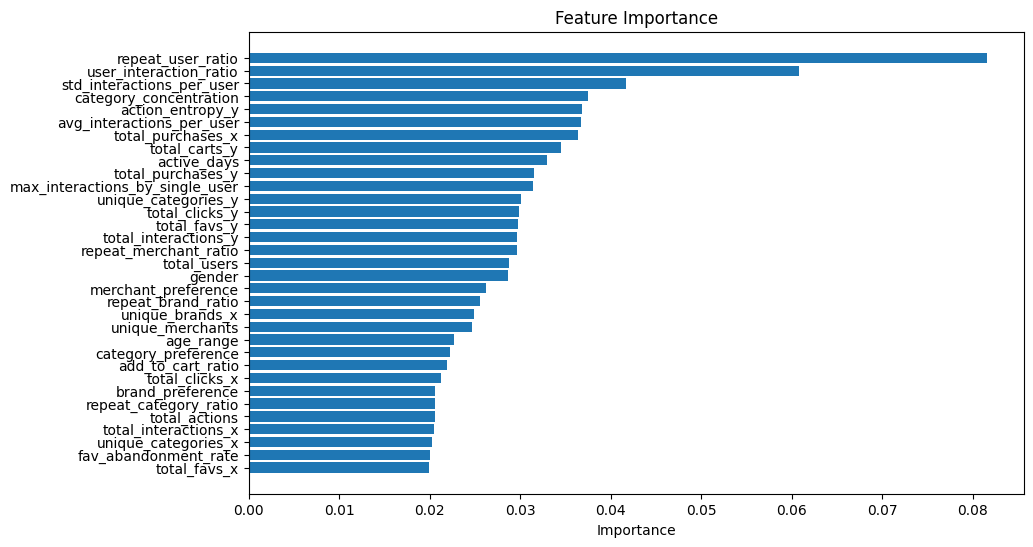

In [49]:
importances = xgb_model.feature_importances_

feature_names = filtered_columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [50]:
test['prob'] = xgb_model.predict_proba(X_test)[:, 1]

# Prepare submission file
submission = test[['user_id', 'merchant_id', 'prob']]
submission.to_csv('prediction.csv', index=False)
print("Submission file created.")

Submission file created.


# Neural Network

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [40]:
# Prepare data
X = train.drop(['label', 'user_id', 'merchant_id'], axis=1)
X = X.dropna()

y = train['label']
y = y[X.index]

X_test = test.drop(['user_id', 'merchant_id', 'prob'], axis=1)

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)
X_test_scaled = scaler_full.transform(X_test)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [42]:
# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(np.array(y_train)).float())
valset = TensorDataset(torch.from_numpy(X_val_scaled).float(), 
                        torch.from_numpy(np.array(y_val)).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [51]:
# Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output(x)
        return self.sigmoid(x)

# Initialize the model
input_dim = X_train.shape[1]

In [54]:
net = NeuralNetwork(input_dim)
# Define the cost / loss function
cost_fn = nn.BCELoss()

# Define the method of updating the weights each iteration (e.g. gradient descent)
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Lower learning rate

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/200], Loss: 1483.6426
Epoch [2/200], Loss: 1453.4839
Epoch [3/200], Loss: 1448.7120
Epoch [4/200], Loss: 1445.7985
Epoch [5/200], Loss: 1443.2128
Epoch [6/200], Loss: 1439.6093
Epoch [7/200], Loss: 1435.6420
Epoch [8/200], Loss: 1434.3178
Epoch [9/200], Loss: 1431.7825
Epoch [10/200], Loss: 1430.6136
Epoch [11/200], Loss: 1428.9309
Epoch [12/200], Loss: 1427.2200
Epoch [13/200], Loss: 1424.5872
Epoch [14/200], Loss: 1423.5334
Epoch [15/200], Loss: 1421.1525
Epoch [16/200], Loss: 1419.5154
Epoch [17/200], Loss: 1418.3829
Epoch [18/200], Loss: 1416.8049
Epoch [19/200], Loss: 1414.1303
Epoch [20/200], Loss: 1413.4805
Epoch [21/200], Loss: 1411.5092
Epoch [22/200], Loss: 1409.3646
Epoch [23/200], Loss: 1408.4018
Epoch [24/200], Loss: 1406.5172
Epoch [25/200], Loss: 1405.8841
Epoch [26/200], Loss: 1403.6479
Epoch [27/200], Loss: 1401.6292
Epoch [28/200], Loss: 1399.7580
Epoch [29/200], Loss: 1399.8452
Epoch [30/200], Loss: 1397.1730
Epoch [31/200], Loss: 1396.1420
Epoch [32/200], L

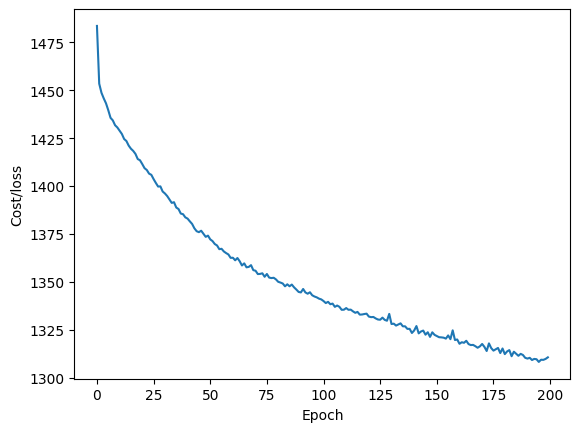

In [55]:
num_iter = 200
cost = []

net = net.to(device)
net.train() # Set the model to training mode

for epoch in range(num_iter):
    
    running_loss = 0.0
  
    for i, data in enumerate(trainloader):
        
        # Get the inputs X and labels y for the minibatch
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients of the weights each iteration
        optimizer.zero_grad()

        # Calculate the predictions and the cost/loss
        outputs = net(inputs).view(-1) # Convert outputs to 1D array instead of 2D to match labels
        loss = cost_fn(outputs, labels)
        
        # Use autograd to calculate the gradient of the cost with respect to each weight
        loss.backward()
        
        # Use the optimizer to do the weights update
        optimizer.step()

        # Store the cost/loss
        running_loss += loss.item()
        
    cost.append(running_loss)
    print(f'Epoch [{epoch+1}/{num_iter}], Loss: {running_loss:.4f}')
    
        
plt.plot(cost)
plt.xlabel('Epoch')
plt.ylabel('Cost/loss')
plt.show()

In [56]:
net.eval()
with torch.no_grad():
    y_true = y_val.tolist()
    test_preds = []

    # Calculate the predictions on the validation set
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        probabilities = net(inputs)  # Forward pass
        # Apply sigmoid if outputs are logits (raw scores)
        # probabilities = torch.sigmoid(outputs).cpu().squeeze().tolist()
        test_preds.extend(probabilities)

    # Calculate AUROC
    auroc = roc_auc_score(y_true, test_preds)
    print(f'Validation AUROC: {auroc:.4f}')


Validation AUROC: 0.5926
